In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import collections

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from __future__ import division
from itertools import zip_longest as zip, count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

import sys
sys.tracebacklimit = 0

In [2]:
#Importing the data

dataset_art_daily_jumpsup=pd.read_csv('C:/Users/Caio Laptop/OneDrive - The University of Kansas/Documents/PhD/11. Courses/19. EECS 731 - Introduction to Data Science/Homework/Section 8 - HW/Datasets/artificialWithAnomaly/artificialWithAnomaly/art_daily_jumpsup.csv')

dataset_realAdExchange2=pd.read_csv('C:/Users/Caio Laptop/OneDrive - The University of Kansas/Documents/PhD/11. Courses/19. EECS 731 - Introduction to Data Science/Homework/Section 8 - HW/Datasets/realAdExchange/realAdExchange/exchange-2_cpc_results.csv')


# Data Exploration

In [3]:
#Taking a look in my data

print("Shape: %s" % str(dataset_art_daily_jumpsup.shape))
print("------------------------------------------------------------------")
print("Column names: %s" % str(dataset_art_daily_jumpsup.columns))
print("------------------------------------------------------------------")
str(dataset_art_daily_jumpsup.info())
print("------------------------------------------------------------------")
print(dataset_art_daily_jumpsup.describe())
print("------------------------------------------------------------------")
dataset_art_daily_jumpsup.head()

Shape: (4032, 2)
------------------------------------------------------------------
Column names: Index(['timestamp', 'value'], dtype='object')
------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
timestamp    4032 non-null object
value        4032 non-null float64
dtypes: float64(1), object(1)
memory usage: 47.3+ KB
------------------------------------------------------------------
             value
count  4032.000000
mean     44.494254
std      32.432473
min      18.001010
25%      19.991382
50%      21.648503
75%      76.435943
max     164.947481
------------------------------------------------------------------


,timestamp,value
0,2014-04-01 00:00:00,19.761252
1,2014-04-01 00:05:00,20.500833
2,2014-04-01 00:10:00,19.961641
3,2014-04-01 00:15:00,21.490266
4,2014-04-01 00:20:00,20.187739


In [4]:
# Plotting the series

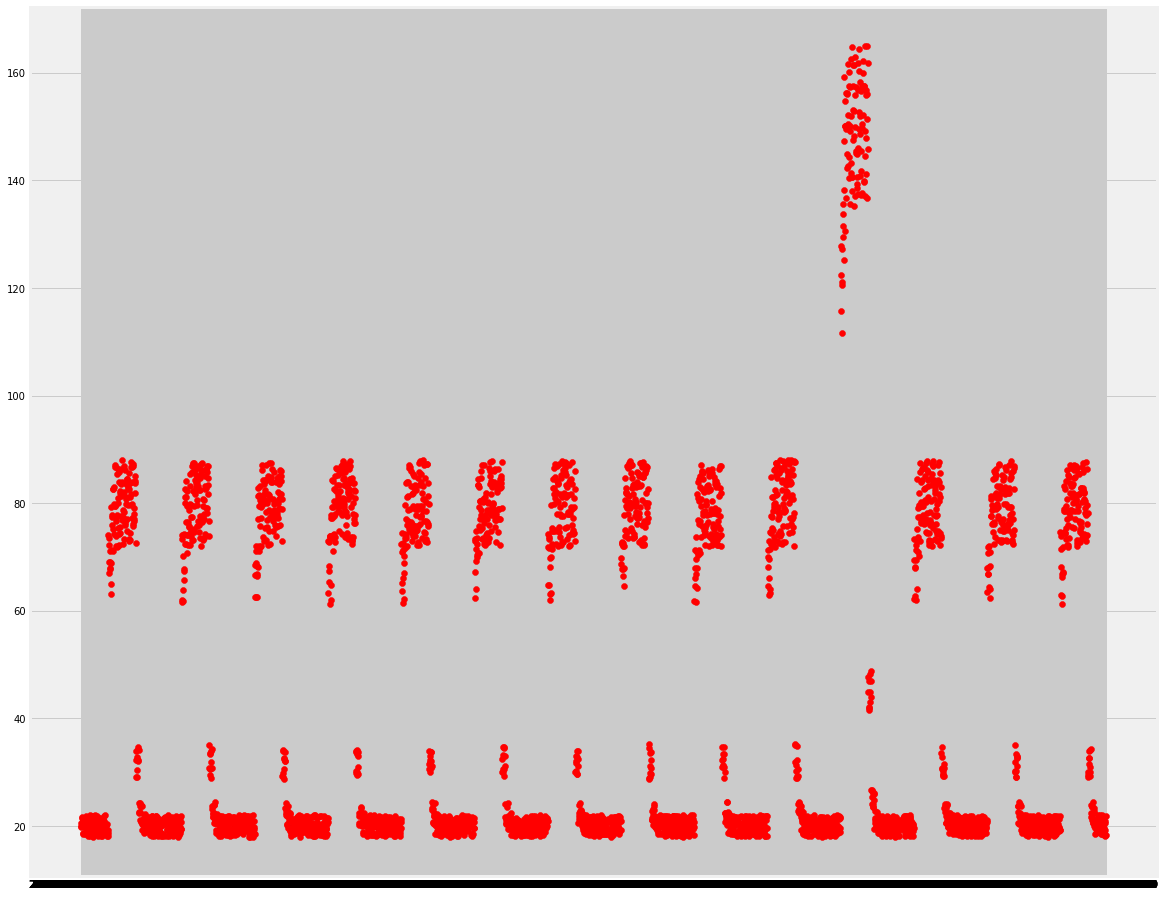

In [5]:
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(111)
ax.scatter(dataset_art_daily_jumpsup['timestamp'], dataset_art_daily_jumpsup['value'], color='red', marker='o')
plt.show()        

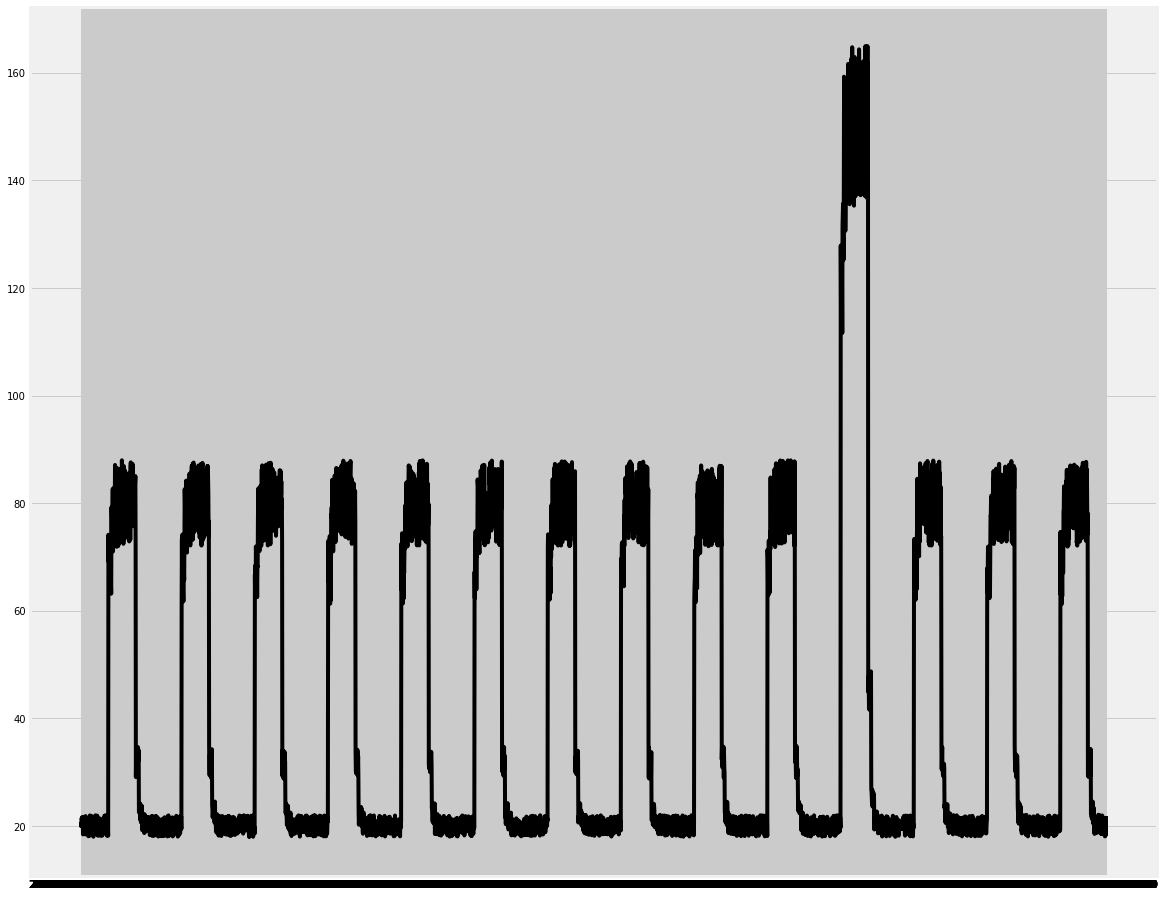

In [6]:
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(111)
ax.plot(dataset_art_daily_jumpsup['timestamp'], dataset_art_daily_jumpsup['value'], color='black')
plt.show() 

In [7]:
#Taking a look in my data

print("Shape: %s" % str(dataset_realAdExchange2.shape))
print("------------------------------------------------------------------")
print("Column names: %s" % str(dataset_realAdExchange2.columns))
print("------------------------------------------------------------------")
str(dataset_realAdExchange2.info())
print("------------------------------------------------------------------")
print(dataset_realAdExchange2.describe())
print("------------------------------------------------------------------")
dataset_realAdExchange2.head()

Shape: (1624, 2)
------------------------------------------------------------------
Column names: Index(['timestamp', 'value'], dtype='object')
------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 2 columns):
timestamp    1624 non-null object
value        1624 non-null float64
dtypes: float64(1), object(1)
memory usage: 19.1+ KB
------------------------------------------------------------------
             value
count  1624.000000
mean      0.101823
std       0.033729
min       0.026843
25%       0.076633
50%       0.100833
75%       0.123618
max       0.226598
------------------------------------------------------------------


,timestamp,value
0,2011-07-01 00:00:01,0.081965
1,2011-07-01 01:00:01,0.098972
2,2011-07-01 02:00:01,0.065314
3,2011-07-01 03:00:01,0.070663
4,2011-07-01 04:00:01,0.102490


In [8]:
# Plotting the series

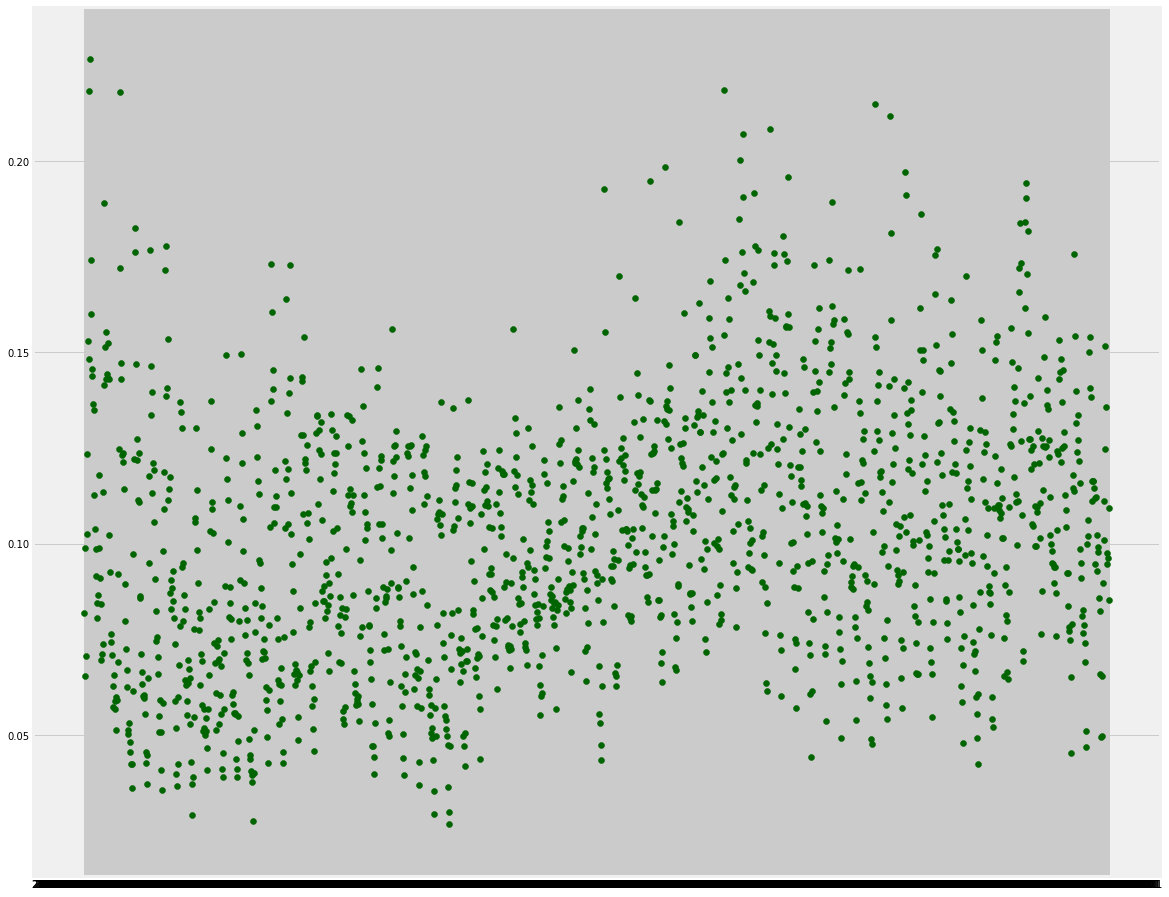

In [9]:
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(111)
ax.scatter(dataset_realAdExchange2['timestamp'], dataset_realAdExchange2['value'], color='darkgreen', marker='o')
plt.show() 

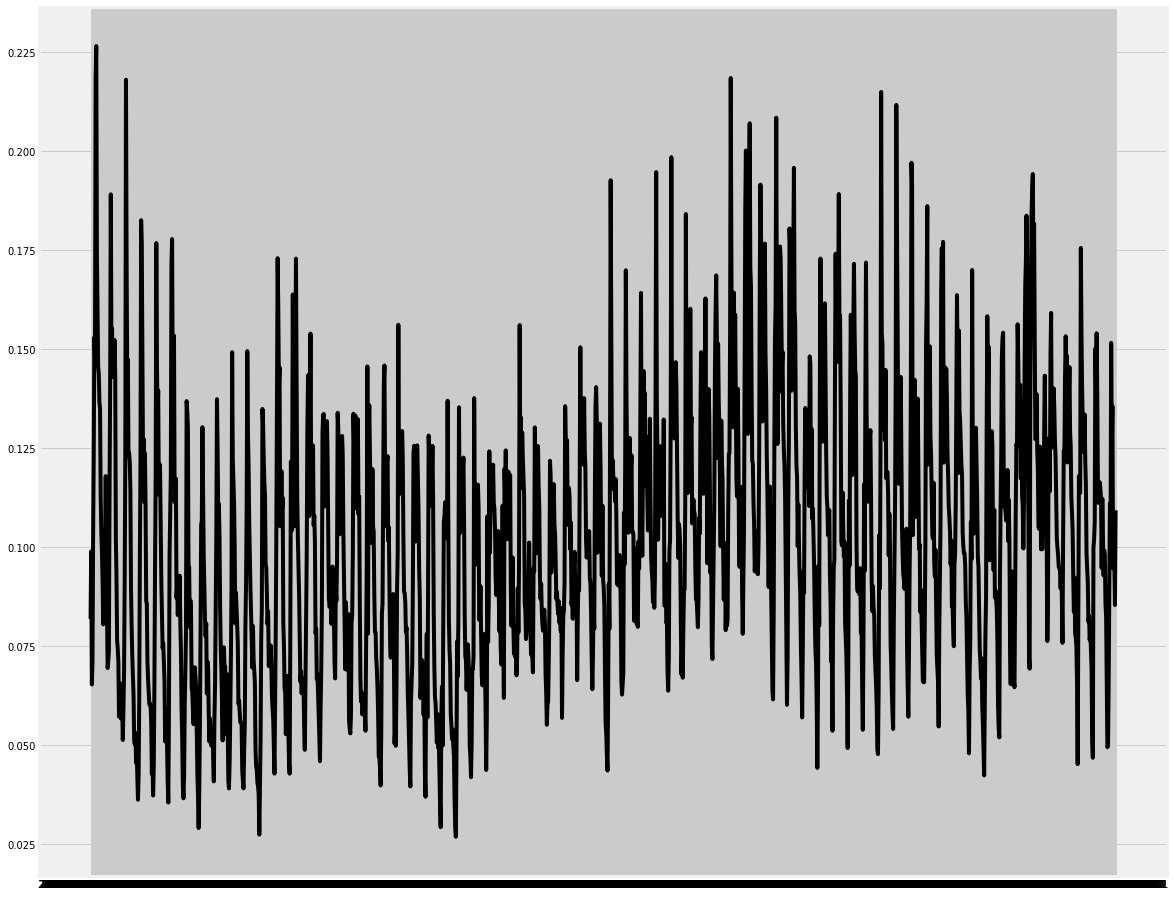

In [10]:
fig = plt.figure(figsize=(18,16))
ax = fig.add_subplot(111)
ax.plot(dataset_realAdExchange2['timestamp'], dataset_realAdExchange2['value'], color='black')
plt.show() 

# Defining the functions

In [11]:
# On thois subsection I define the functions to use moving average

# I'm using the functions from: https://www.datascience.com/blog/python-anomaly-detection

In [12]:
# Defining some use-case specific UDF(User Defined Functions)

def moving_average(data, window_size):
    """ Computes moving average using discrete linear convolution of two one dimensional sequences.
    Args:
    -----
            data (pandas.Series): independent variable
            window_size (int): rolling window size

    Returns:
    --------
            ndarray of linear convolution

    References:
    ------------
    [1] Wikipedia, "Convolution", http://en.wikipedia.org/wiki/Convolution.
    [2] API Reference: https://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html

    """
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

In [13]:
def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in zip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}

In [14]:
def explain_anomalies(y, window_size, sigma=1.0):
  """ Helps in exploring the anamolies using stationary standard deviation
  Args:
  -----
      y (pandas.Series): independent variable
      window_size (int): rolling window size
      sigma (int): value for standard deviation

  Returns:
  --------
      a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
      containing information about the points indentified as anomalies

  """
  avg = moving_average(y, window_size).tolist()
  residual = y - avg
  # Calculate the variation in the distribution of the residual
  std = np.std(residual)
  return {'standard_deviation': round(std, 3),
          'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                     index, y_i, avg_i in zip(count(), y, avg)
            if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}

In [15]:
def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    """ Helps in exploring the anamolies using rolling standard deviation
    Args:
    -----
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma (int): value for standard deviation

    Returns:
    --------
        a dict (dict of 'standard_deviation': int, 'anomalies_dict': (index: value))
        containing information about the points indentified as anomalies
    """
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in zip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}

In [16]:
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False):
    """ Helps in generating the plot and flagging the anamolies.
        Supports both moving and stationary standard deviation. Use the 'applying_rolling_std' to switch
        between the two.
    Args:
    -----
        x (pandas.Series): dependent variable
        y (pandas.Series): independent variable
        window_size (int): rolling window size
        sigma_value (int): value for standard deviation
        text_xlabel (str): label for annotating the X Axis
        text_ylabel (str): label for annotatin the Y Axis
        applying_rolling_std (boolean): True/False for using rolling vs stationary standard deviation
    """
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green')
    plt.xlim(0, 1000)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    
    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

# Applying the Moving Average codes and Plotting

## (1) First I will try on dataset_realAdExchange2

### Trying Window size = 3

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

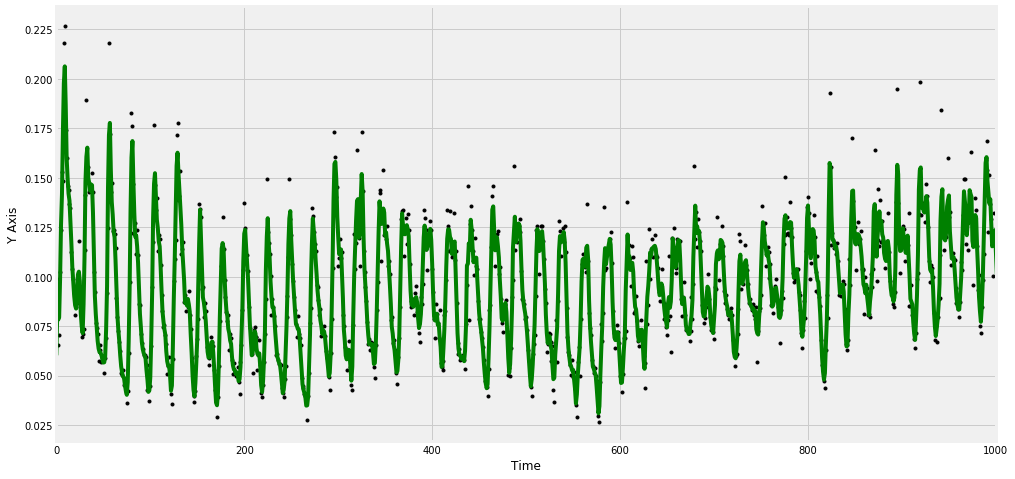

In [17]:
x = dataset_realAdExchange2.index.values.astype(int)
Y = dataset_realAdExchange2['value']

# plot the results
plot_results(x, y=Y, window_size=3, text_xlabel="Time", sigma_value=3)
events = explain_anomalies_rolling_std(y, window_size=3, sigma=3)

### Trying Window size = 10

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

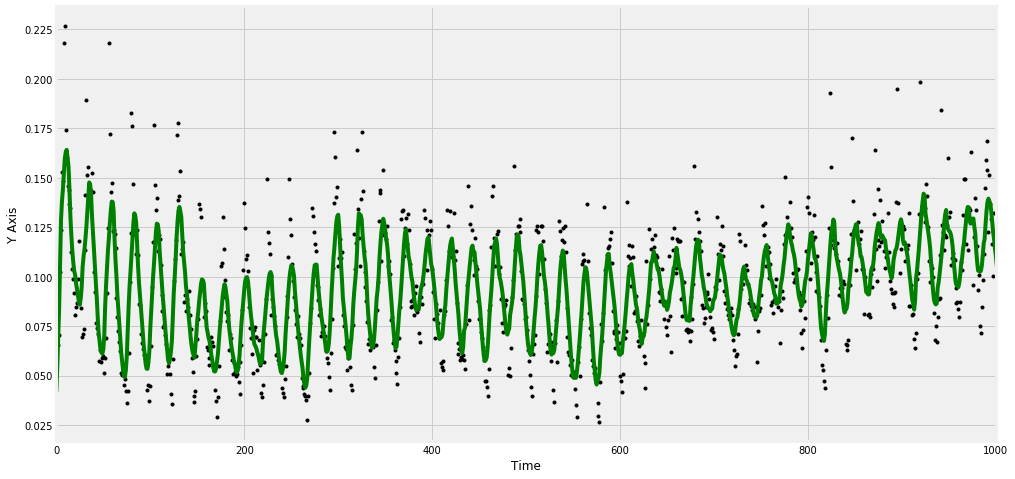

In [18]:
x = dataset_realAdExchange2.index.values.astype(int)
Y = dataset_realAdExchange2['value']

# plot the results
plot_results(x, y=Y, window_size=10, text_xlabel="Time", sigma_value=3)
events = explain_anomalies_rolling_std(y, window_size=10, sigma=3)

## (2) Now I will try on dataset_art_daily_jumpsup

### Trying Window size = 5

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

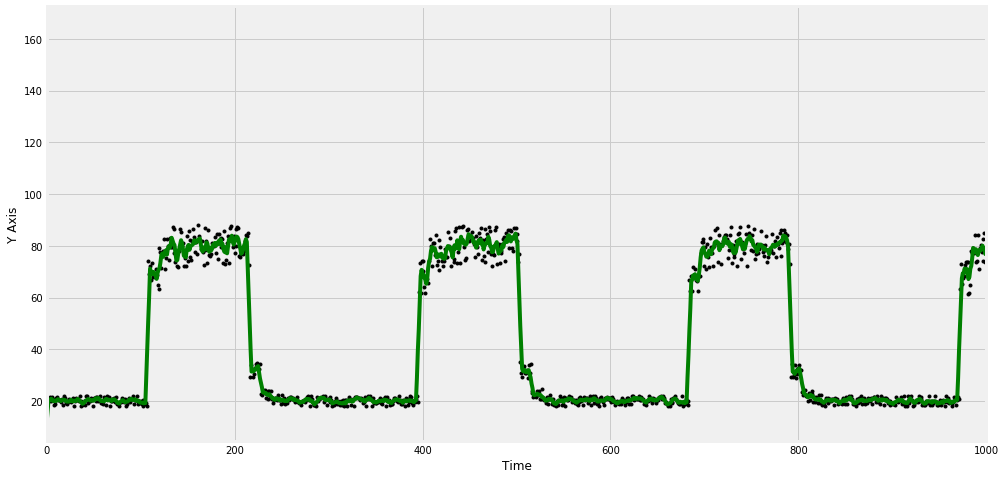

In [19]:
x = dataset_art_daily_jumpsup.index.values.astype(int)
Y = dataset_art_daily_jumpsup['value']

# plot the results
plot_results(x, y=Y, window_size=5, text_xlabel="Time", sigma_value=2)
events = explain_anomalies(y, window_size=5, sigma=2)

### Trying Window size = 15

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
AssertionError


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

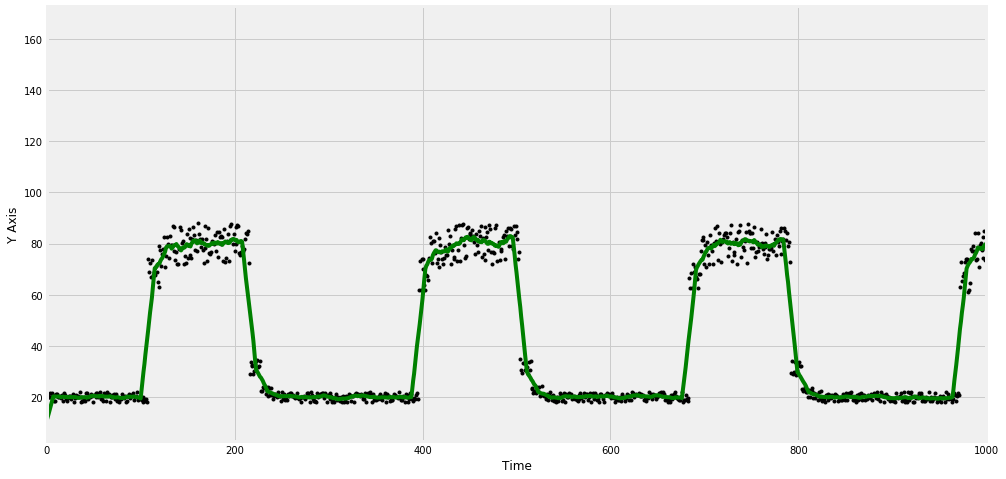

In [20]:
x = dataset_art_daily_jumpsup.index.values.astype(int)
Y = dataset_art_daily_jumpsup['value']

# plot the results
plot_results(x, y=Y, window_size=15, text_xlabel="Time", sigma_value=2)
events = explain_anomalies(y, window_size=15, sigma=2)